# **Title: Detecting and Anonymizing PII in Educational Texts Using NLP**


### **Team Member**:

Varshith Reddy Bhimireddy (G24438222)

Areena Syed (G27076814)

Kanishk Goel (G38260706)

## **1. Introduction**

### **Problem**

In the digital age, educational platforms generate vast amounts of data, offering opportunities to improve learning and research. However, this data often contains sensitive information, known as Personally Identifiable Information (PII), which must be protected to ensure privacy. This project focuses on detecting and anonymizing PII in educational datasets using advanced machine learning models like BERT. By identifying sensitive details such as names, email addresses, and phone numbers, this approach ensures data can be safely used for research without compromising privacy. This work highlights the importance of safeguarding personal information while maximizing the value of educational data.

### **Motivation**

PII detection and anonymization enable:

1. Data Privacy: Ensuring sensitive student information is not exposed.
2. Research Enablement: Allowing educational data to be shared and analyzed safely.
3. Regulatory Compliance: Meeting legal obligations under data protection frameworks.

By using state-of-the-art NLP models like BERT, this project demonstrates a scalable solution for handling PII in educational datasets.

## **2. Experiment**

### **2.1 Dataset**

##### **Overview**

This project uses a dataset containing approximately 22,000 student essays, collected from a Massive Open Online Course (MOOC). These essays were written in response to a standardized prompt and serve as a valuable source of natural language data for our analysis. The dataset is available in JSON format, making it easy to handle and process for machine learning tasks.

##### **Dataset Composition**

The dataset is predominantly composed of test essays, accounting for about 70% of the total data. Key features of the dataset include:

- Document Identifier: A unique ID for each essay for easy reference.
- Full Text: Essays in UTF-8 format, ensuring consistency across systems.
- Tokens and Annotations: Essays are tokenized using the SpaCy English tokenizer, and annotations are in BIO format. This structure helps identify different types of personally identifiable information (PII).

##### **Types of PII**

1. NAME_STUDENT: Names directly associated with individual students.
2. EMAIL: Email addresses that could be used to contact or identify a student.
3. USERNAME: Usernames that might be linked to student profiles on various platforms.
4. ID_NUM: Identifiable numbers, such as student IDs or social security numbers.
5. PHONE_NUM: Telephone numbers associated with students.
6. URL_PERSONAL: Personal URLs that could directly or indirectly identify a student.
7. STREET_ADDRESS: Residential addresses, either complete or partial, that are tied to students.

##### **Privacy Measures**

The dataset has been preprocessed to replace real PII with surrogate identifiers to maintain privacy while preserving data structure.

## **Data Importing**

In [ ]:
import numpy as np
import re
import pandas as pd
import functools
from itertools import chain
from functools import partial
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import numpy as np
import torch.nn as nn
from sklearn.metrics import classification_report
from torch import nn
import random

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive'

## **Data Loading**

In [ ]:
traindf = pd.read_json(r'C:\Users\sujit\Desktop\varshith\dataset\train.json')
testdf = pd.read_json(r'C:\Users\sujit\Desktop\varshith\dataset\test.json')
traindata = pd.read_csv(r'C:\Users\sujit\Desktop\varshith\dataset\pii_dataset.csv')

In [ ]:
traindata

,document,text,tokens,trailing_whitespace,labels,prompt,prompt_id,name,email,phone,job,address,username,url,hobby,len
0,1073d46f-2241-459b-ab01-851be8d26436,"My name is Aaliyah Popova, and I am a jeweler ...","['My', 'name', 'is', 'Aaliyah', 'Popova,', 'an...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Aaliyah Popova is a jeweler with 13 year...,1,Aaliyah Popova,aaliyah.popova4783@aol.edu,(95) 94215-7906,jeweler,97 Lincoln Street,NaN,NaN,Podcasting,363
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"My name is Konstantin Becker, and I'm a develo...","['My', 'name', 'is', 'Konstantin', 'Becker,', ...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Konstantin Becker is a developer with 2 ...,1,Konstantin Becker,konstantin.becker@gmail.com,0475 4429797,developer,826 Webster Street,NaN,NaN,Quilting,255
2,353da41e-7799-4071-ab20-d959b362612e,"As Mieko Mitsubishi, an account manager at a p...","['As', 'Mieko', 'Mitsubishi,', 'an', 'account'...","[True, True, True, True, True, True, True, Tru...","['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'O',...",\n Mieko Mitsubishi is a account manager. W...,3,Mieko Mitsubishi,mieko_mitsubishi@msn.org,+27 61 222 4762,account manager,1309 Southwest 71st Terrace,NaN,NaN,Metal detecting,259
3,9324ee01-7bdc-41b1-a7a5-01307f72c20d,"My name is Kazuo Sun, and I'm an air traffic c...","['My', 'name', 'is', 'Kazuo', 'Sun,', 'and', ""...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Kazuo Sun is a air traffic controller wi...,1,Kazuo Sun,kazuosun@hotmail.net,0304 2215930,air traffic controller,736 Sicard Street Southeast,NaN,NaN,Amateur radio,281
4,971fe266-2739-4f1b-979b-7f64e07d5a4a,"My name is Arina Sun, and I'm a dental hygieni...","['My', 'name', 'is', 'Arina', 'Sun,', 'and', ""...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Arina Sun is a dental hygienist. Write a...,3,Arina Sun,arina-sun@gmail.net,0412 1245924,dental hygienist,5701 North 67th Avenue,NaN,NaN,Related,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429,a90b6b71-0e77-4089-a3a4-9a5b5c5aec78,"Hello, I'm Nicholas Moore, a man with a rich t...","['Hello,', ""I'm"", 'Nicholas', 'Moore,', 'a', '...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUDENT',...",\n Write a fictional semi-formal biography ...,0,Nicholas Moore,nicholas_moore8047@yahoo.gov,+91-63720 22261,videographer,35915 Patrick Mews Suite 978,n.moore,https://www.nmoore.org,Surfing,360
4430,1492ed0e-f162-424f-9c40-f3edde790ca1,"Hello, my name is Alexey Novikov and I'm a psy...","['Hello,', 'my', 'name', 'is', 'Alexey', 'Novi...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME...",\n Alexey Novikov is a psychologist. Write ...,3,Alexey Novikov,alexey.novikov@msn.gov,0264 828 4342,psychologist,161 Creek Road,NaN,NaN,Gardening,248
4431,57ef34c1-48db-4413-9573-774021e57f63,"My name is Ludmila Inoue, and I'm a person wit...","['My', 'name', 'is', 'Ludmila', 'Inoue,', 'and...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Write a fictional semi-formal biography ...,0,Ludmila Inoue,ludmila_inoue@outlook.net,(285) 815-7373,physician,706 Seagrove Road,NaN,NaN,Quilting,445
4432,a4486627-1c62-48b0-bf4f-53259ecc0a28,"Dr. Tu Garcia, a renowned dermatologist, embar...","['Dr.', 'Tu', 'Garcia,', 'a', 'renowned', 'der...","[True, True, True, True, True, True, True, Tru...","['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'O',...",\n Tu Garcia is a dermatologist. Write abou...,2,Tu Garcia,tugarcia@outlook.com,+91-14426 83047,dermatologist,1677 Anthony Run,t.garcia,http://blog.tu-garcia.edu,Skiing,320


In [ ]:
traindf

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
testdf

,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True..."
7,104,Storytelling The Path to Innovation\n\nDr Sak...,"[Storytelling, , The, Path, to, Innovation, \...","[True, False, True, True, True, False, False, ..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ..."
9,123,Gandhi Institute of Technology and Management ...,"[Gandhi, Institute, of, Technology, and, Manag...","[True, True, True, True, True, True, False, Tr..."


In [ ]:
max_value = traindf['document'].max()
max_value

np.int64(22687)

### **2.2. Data Preprocessing**

Data preprocessing is a critical step in preparing the dataset for effective model training and evaluation. Below is an overview of the preprocessing steps carried out in this project:

- Loaded and merged multiple datasets.
- Cleaned tokens and labels to remove anomalies and whitespace.
- Added `[CLS]` and `[SEP]` tokens to indicate sentence boundaries.
- Handled misaligned tokens and labels to ensure consistency.
- Split the dataset into training, validation, and test sets.

##### **Converting JSON to DataFrame**

The initial dataset was in JSON format. It was converted into a Pandas DataFrame for easy handling and analysis. Additional rows were concatenated with the primary dataset to create a unified dataset.



In [ ]:
# Checking the type of 'tokens' and 'labels' columns. If they are strings and we need to convert it into lists in traindf.
print(type(traindf['tokens'][0]))
print(type(traindf['labels'][0]))

<class 'list'>
<class 'list'>


In [ ]:
import ast

if isinstance(traindf['tokens'][0], str):
    traindf['tokens'] = traindf['tokens'].apply(ast.literal_eval)
if isinstance(traindf['labels'][0], str):
    traindf['labels'] = traindf['labels'].apply(ast.literal_eval)


In [ ]:
# Checking the type of 'tokens' and 'labels' columns. If they are strings and we need to convert it into lists in traindata.
print(type(traindata['tokens'].iloc[0]))
print(type(traindata['labels'].iloc[0]))

<class 'str'>
<class 'str'>


In [ ]:
import ast

if isinstance(traindata['tokens'].iloc[0], str):
    traindata['tokens'] = traindata['tokens'].apply(ast.literal_eval)
if isinstance(traindata['labels'].iloc[0], str):
    traindata['labels'] = traindata['labels'].apply(ast.literal_eval)

print(type(traindata['tokens'].iloc[0]))
print(type(traindata['labels'].iloc[0]))

<class 'list'>
<class 'list'>


In [ ]:
traindata

,document,text,tokens,trailing_whitespace,labels,prompt,prompt_id,name,email,phone,job,address,username,url,hobby,len
0,1073d46f-2241-459b-ab01-851be8d26436,"My name is Aaliyah Popova, and I am a jeweler ...","[My, name, is, Aaliyah, Popova,, and, I, am, a...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",\n Aaliyah Popova is a jeweler with 13 year...,1,Aaliyah Popova,aaliyah.popova4783@aol.edu,(95) 94215-7906,jeweler,97 Lincoln Street,NaN,NaN,Podcasting,363
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"My name is Konstantin Becker, and I'm a develo...","[My, name, is, Konstantin, Becker,, and, I'm, ...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",\n Konstantin Becker is a developer with 2 ...,1,Konstantin Becker,konstantin.becker@gmail.com,0475 4429797,developer,826 Webster Street,NaN,NaN,Quilting,255
2,353da41e-7799-4071-ab20-d959b362612e,"As Mieko Mitsubishi, an account manager at a p...","[As, Mieko, Mitsubishi,, an, account, manager,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O...",\n Mieko Mitsubishi is a account manager. W...,3,Mieko Mitsubishi,mieko_mitsubishi@msn.org,+27 61 222 4762,account manager,1309 Southwest 71st Terrace,NaN,NaN,Metal detecting,259
3,9324ee01-7bdc-41b1-a7a5-01307f72c20d,"My name is Kazuo Sun, and I'm an air traffic c...","[My, name, is, Kazuo, Sun,, and, I'm, an, air,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",\n Kazuo Sun is a air traffic controller wi...,1,Kazuo Sun,kazuosun@hotmail.net,0304 2215930,air traffic controller,736 Sicard Street Southeast,NaN,NaN,Amateur radio,281
4,971fe266-2739-4f1b-979b-7f64e07d5a4a,"My name is Arina Sun, and I'm a dental hygieni...","[My, name, is, Arina, Sun,, and, I'm, a, denta...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",\n Arina Sun is a dental hygienist. Write a...,3,Arina Sun,arina-sun@gmail.net,0412 1245924,dental hygienist,5701 North 67th Avenue,NaN,NaN,Related,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429,a90b6b71-0e77-4089-a3a4-9a5b5c5aec78,"Hello, I'm Nicholas Moore, a man with a rich t...","[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[True, True, True, True, True, True, True, Tru...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O...",\n Write a fictional semi-formal biography ...,0,Nicholas Moore,nicholas_moore8047@yahoo.gov,+91-63720 22261,videographer,35915 Patrick Mews Suite 978,n.moore,https://www.nmoore.org,Surfing,360
4430,1492ed0e-f162-424f-9c40-f3edde790ca1,"Hello, my name is Alexey Novikov and I'm a psy...","[Hello,, my, name, is, Alexey, Novikov, and, I...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...",\n Alexey Novikov is a psychologist. Write ...,3,Alexey Novikov,alexey.novikov@msn.gov,0264 828 4342,psychologist,161 Creek Road,NaN,NaN,Gardening,248
4431,57ef34c1-48db-4413-9573-774021e57f63,"My name is Ludmila Inoue, and I'm a person wit...","[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",\n Write a fictional semi-formal biography ...,0,Ludmila Inoue,ludmila_inoue@outlook.net,(285) 815-7373,physician,706 Seagrove Road,NaN,NaN,Quilting,445
4432,a4486627-1c62-48b0-bf4f-53259ecc0a28,"Dr. Tu Garcia, a renowned dermatologist, embar...","[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O...",\n Tu Garcia is a dermatologist. Write abou...,2,Tu Garcia,tugarcia@outlook.com,+91-14426 83047,dermatologist,1677 Anthony Run,t.garcia,http://blog.tu-garcia.edu,Skiing,320


In [ ]:
traindata = traindata[['document','tokens','trailing_whitespace','labels']]
traindata

,document,tokens,trailing_whitespace,labels
0,1073d46f-2241-459b-ab01-851be8d26436,"[My, name, is, Aaliyah, Popova,, and, I, am, a...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"[My, name, is, Konstantin, Becker,, and, I'm, ...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
2,353da41e-7799-4071-ab20-d959b362612e,"[As, Mieko, Mitsubishi,, an, account, manager,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."
3,9324ee01-7bdc-41b1-a7a5-01307f72c20d,"[My, name, is, Kazuo, Sun,, and, I'm, an, air,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
4,971fe266-2739-4f1b-979b-7f64e07d5a4a,"[My, name, is, Arina, Sun,, and, I'm, a, denta...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
...,...,...,...,...
4429,a90b6b71-0e77-4089-a3a4-9a5b5c5aec78,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[True, True, True, True, True, True, True, Tru...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
4430,1492ed0e-f162-424f-9c40-f3edde790ca1,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
4431,57ef34c1-48db-4413-9573-774021e57f63,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
4432,a4486627-1c62-48b0-bf4f-53259ecc0a28,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
traindf = traindf.drop(columns=['full_text'])
traindf

,document,tokens,trailing_whitespace,labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...
6802,22678,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# Assing new squential ID for train data
traindata['document'] = range(23000 , len(traindata) + 23000)

traindata

C:\Users\sujit\AppData\Local\Temp\ipykernel_17200\648207755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata['document'] = range(23000 , len(traindata) + 23000)


,document,tokens,trailing_whitespace,labels
0,23000,"[My, name, is, Aaliyah, Popova,, and, I, am, a...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
1,23001,"[My, name, is, Konstantin, Becker,, and, I'm, ...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
2,23002,"[As, Mieko, Mitsubishi,, an, account, manager,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."
3,23003,"[My, name, is, Kazuo, Sun,, and, I'm, an, air,...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
4,23004,"[My, name, is, Arina, Sun,, and, I'm, a, denta...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
...,...,...,...,...
4429,27429,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[True, True, True, True, True, True, True, Tru...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
4430,27430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
4431,27431,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
4432,27432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
#Checking for null values

print(traindata.isnull().sum())


document               0
tokens                 0
trailing_whitespace    0
labels                 0
dtype: int64


In [ ]:
print(traindf.isnull().sum())

document               0
tokens                 0
trailing_whitespace    0
labels                 0
dtype: int64


In [ ]:
token_label = pd.concat([traindf,traindata], ignore_index=True)

In [ ]:
token_label

,document,tokens,trailing_whitespace,labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...
11236,27429,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[True, True, True, True, True, True, True, Tru...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
11237,27430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[True, True, True, True, True, True, True, Tru...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
11238,27431,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[True, True, True, True, True, True, True, Tru...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
11239,27432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[True, True, True, True, True, True, True, Tru...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
token_label = token_label.drop(columns=['trailing_whitespace'])

In [ ]:
token_label

,document,tokens,labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[Design, Thinking, for, Innovation, \n\n, Sind...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[Assignment, :, , Visualization, , Reflecti...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...
11236,27429,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
11237,27430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
11238,27431,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
11239,27432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
# # # Saving the 'results' DataFrame to a CSV file
token_label.to_csv(r'C:\Users\sujit\Desktop\varshith\dataset\token-labels.csv', index=False)  # Set index=False to avoid writing row indices


In [ ]:
df = token_label
df

,document,tokens,labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[Design, Thinking, for, Innovation, \n\n, Sind...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[Assignment, :, , Visualization, , Reflecti...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...
11236,27429,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
11237,27430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
11238,27431,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
11239,27432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
# Creating a list of unique labels
unique_labels1 = token_label['labels'].explode().unique()
unique_labels1

unique_labels = [
    'O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-EMAIL',
    'B-ID_NUM', 'I-URL_PERSONAL', 'B-USERNAME', 'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'I-ID_NUM'
]

# Create a dictionary to map label indices to their respective labels

id2label = {i: label for i, label in enumerate(unique_labels)}



#####  **Cleaning Tokens and Labels**

Tokens and labels were processed to ensure consistency, remove unnecessary whitespace, and handle anomalies. Any token with invalid or missing data was discarded along with its corresponding label. This step is vital for improving data quality and preventing errors during tokenization.

In [ ]:
import re
import ast

def clean_words_and_labels(tokens, labels):
    # Clean words and remove corresponding labels if the word is just whitespace or empty after cleaning.
    cleaned_tokens = []
    cleaned_labels = []
    for token, label in zip(tokens, labels):
        # Apply any specific cleaning necessary for each word
        cleaned_token = re.sub(r'\s+', '', token).strip()
        # Only add words and labels that are not empty after cleaning
        if cleaned_token:
            cleaned_tokens.append(cleaned_token)
            cleaned_labels.append(label)
    return cleaned_tokens, cleaned_labels

# Assuming 'words' and 'labels' columns contain string representations of lists
# Convert string representation of a list to actual list
# Instead of using ast.literal_eval directly, we'll use a custom function
def safe_eval(text):
    try:
        return ast.literal_eval(text)
    except (SyntaxError, ValueError):
        # If literal_eval fails, assume it's a regular string and return as is
        # You might want to add more specific error handling if needed
        return text

df['tokens'] = df['tokens'].apply(safe_eval)  # Using the safe_eval function
df['labels'] = df['labels'].apply(safe_eval)  # Using the safe_eval function

# Apply the cleaning function to each pair of words and labels
cleaned_data = df.apply(lambda row: clean_words_and_labels(row['tokens'], row['labels']), axis=1)

# Separate the cleaned words and labels into their own columns
df['cleaned_tokens'] = cleaned_data.apply(lambda x: x[0])
df['cleaned_labels'] = cleaned_data.apply(lambda x: x[1])

In [ ]:
df.drop(columns=['tokens','labels'],inplace=True)

In [ ]:
df

,document,cleaned_tokens,cleaned_labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, Design, Thinking, Assignment,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
3,20,"[Design, Thinking, for, Innovation, Sindy, Sam...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
4,56,"[Assignment, :, Visualization, Reflection, Sub...","[O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_S..."
...,...,...,...
11236,27429,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
11237,27430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
11238,27431,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
11239,27432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
# Function to remove quotes from tokens
def remove_quotes(tokens):
    # Replace single and double quotes from each token
    return [token.replace("'", "").replace('"', "") for token in tokens]

# Apply the function to remove quotes from the cleaned_tokens column
df['cleaned_tokens'] = df['cleaned_tokens'].apply(remove_quotes)


##### **Token-Label Alignment**

In tasks like PII detection, every token (word) in the dataset must have a matching label. Sometimes, errors during data processing can cause the number of tokens and labels to mismatch, leading to problems during model training. To fix this, we used the fix_alignment function to find and review any rows with misaligned tokens and labels. The function also shows sample sentences with their tokens and labels for manual checking.

At the end of this process, we ensure all tokens and labels are properly aligned. This step helps create a clean dataset, improves model performance, and ensures accurate results during training and testing.



In [ ]:
def fix_alignment(df, start_index=0, num_sentences=3):
    # Check for alignment issues
    misaligned_rows = df[df['cleaned_tokens'].apply(len) != df['cleaned_labels'].apply(len)]

    if not misaligned_rows.empty:
        print(f"Number of misaligned rows: {len(misaligned_rows)}")
        print("Sample of misaligned rows:")
        print(misaligned_rows[['cleaned_tokens', 'cleaned_labels']].head())
    else:
        print("All rows are perfectly aligned.")

    # Display cleaned words and labels for the specified range
    print(f"\nDisplaying {num_sentences} sentences starting from index {start_index}:\n")
    for index in range(start_index, start_index + num_sentences):
        if index >= len(df):
            print("No more sentences available to display.")
            break
        tokens = df['cleaned_tokens'].iloc[index]
        labels = df['cleaned_labels'].iloc[index]
        print(f"Sentence {index}:")
        for token, label in zip(tokens, labels):
            print(f"{token}: {label}")
        print("\n" + "-"*40)

fix_alignment(df, start_index=2, num_sentences=3)

All rows are perfectly aligned.

Displaying 3 sentences starting from index 2:

Sentence 2:
Reporting: O
process: O
by: O
Gilberto: B-NAME_STUDENT
Gamboa: I-NAME_STUDENT
Challenge: O
I: O
received: O
a: O
promotion: O
of: O
being: O
the: O
Regional: O
Controller: O
,: O
along: O
with: O
my: O
actual: O
position: O
of: O
Country: O
CFO: O
.: O
The: O
main: O
responsibility: O
of: O
this: O
new: O
position: O
was: O
to: O
weekly: O
report: O
the: O
results: O
for: O
the: O
week: O
and: O
estimate: O
the: O
final: O
results: O
of: O
the: O
month: O
of: O
4: O
countries: O
and: O
consolidated: O
those: O
.: O
When: O
I: O
was: O
receiving: O
the: O
position: O
,: O
I: O
went: O
to: O
visit: O
my: O
colleague: O
,: O
former: O
Regional: O
Controller: O
,: O
who: O
was: O
promoted: O
to: O
Country: O
CEO: O
and: O
now: O
had: O
interest: O
conflicts: O
of: O
being: O
the: O
controller: O
.: O
The: O
process: O
to: O
consolidate: O
the: O
information: O
of: O
the: O
4: O
countries: O
was: O
t

### **2.3 Exploratory Data Analysis**

##### **Objective of EDA:**

The purpose of the Exploratory Data Analysis (EDA) is to:

- Understand the structure and characteristics of the dataset.
- Identify the distribution of labels and tokens.
- Explore relationships between sentence length and PII density.
- Visualize the token distribution for PII and non-PII data.

##### **Token Frequency by Label**


Most common tokens for label 'O':


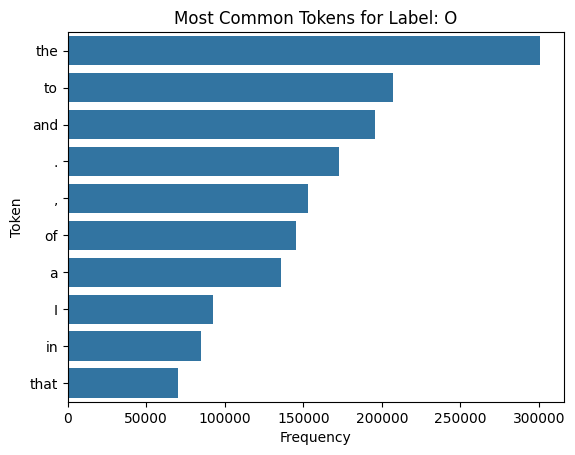


Most common tokens for label 'B-NAME_STUDENT':


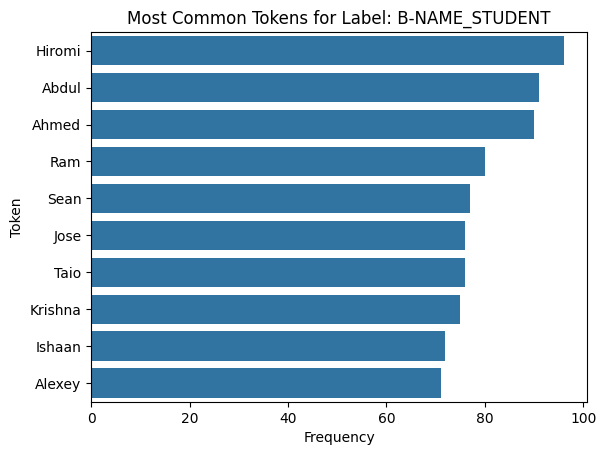


Most common tokens for label 'I-NAME_STUDENT':


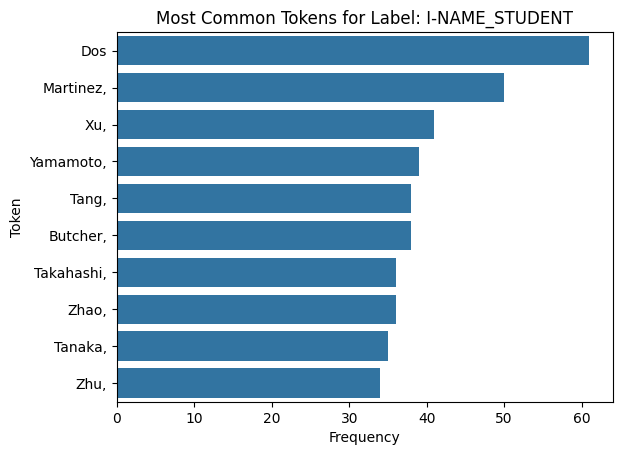


Most common tokens for label 'B-URL_PERSONAL':


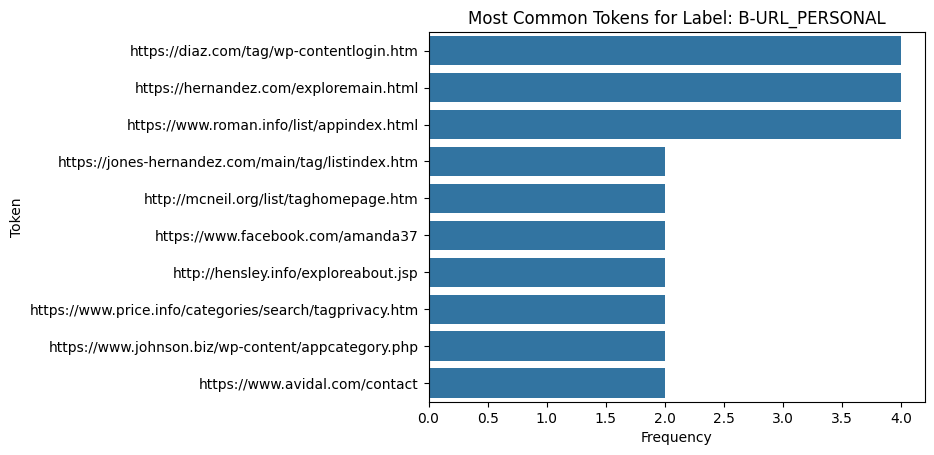


Most common tokens for label 'B-EMAIL':


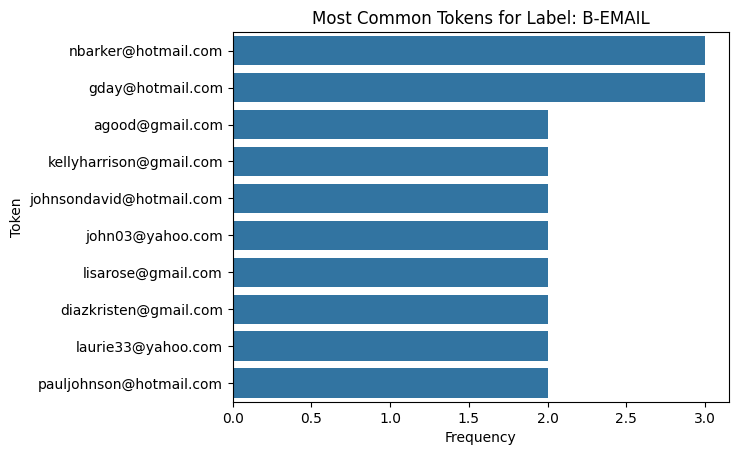


Most common tokens for label 'B-ID_NUM':


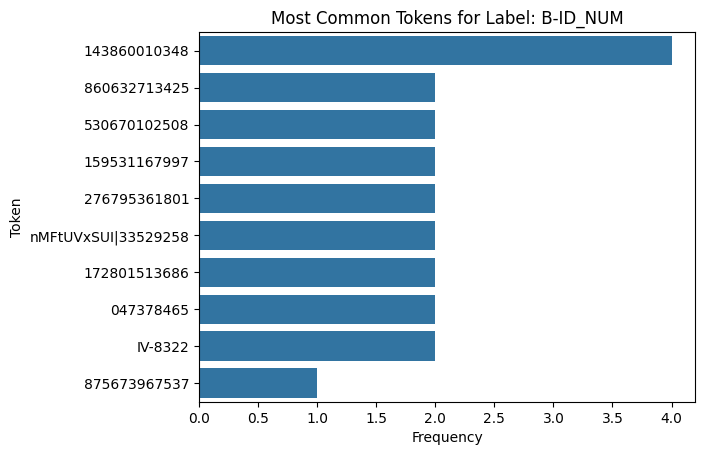


Most common tokens for label 'I-URL_PERSONAL':


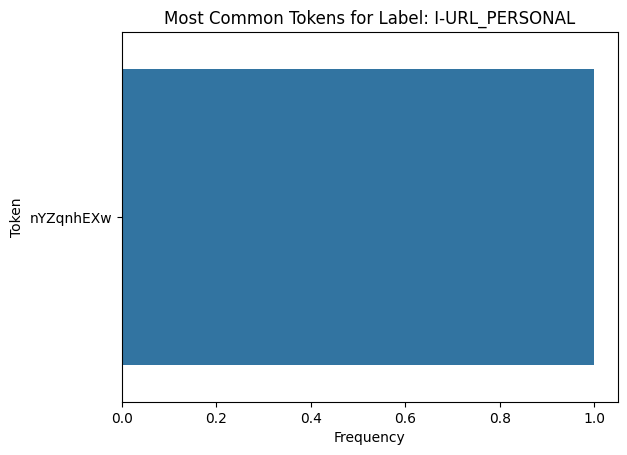


Most common tokens for label 'B-USERNAME':


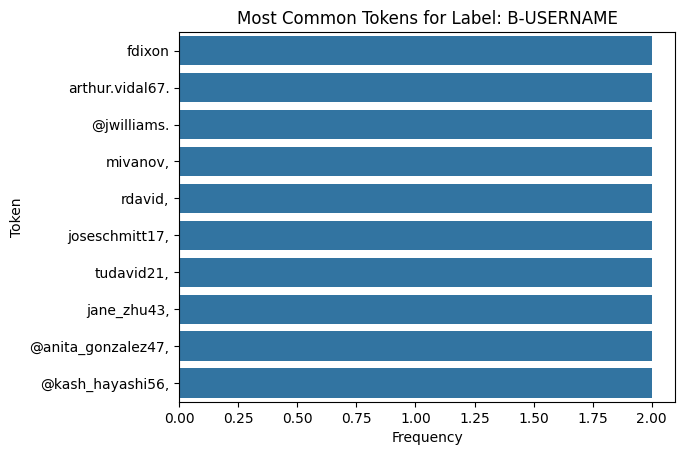


Most common tokens for label 'B-PHONE_NUM':


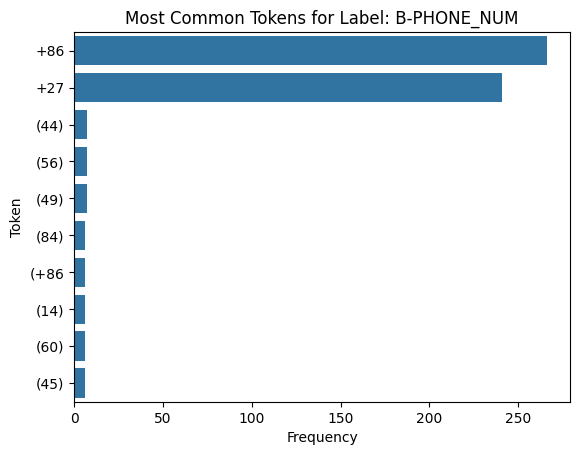


Most common tokens for label 'I-PHONE_NUM':


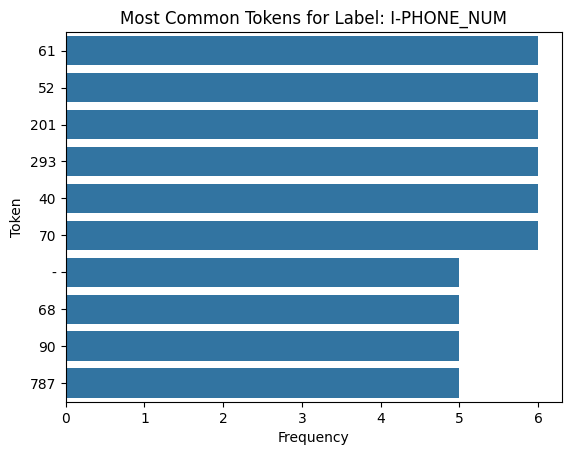


Most common tokens for label 'B-STREET_ADDRESS':


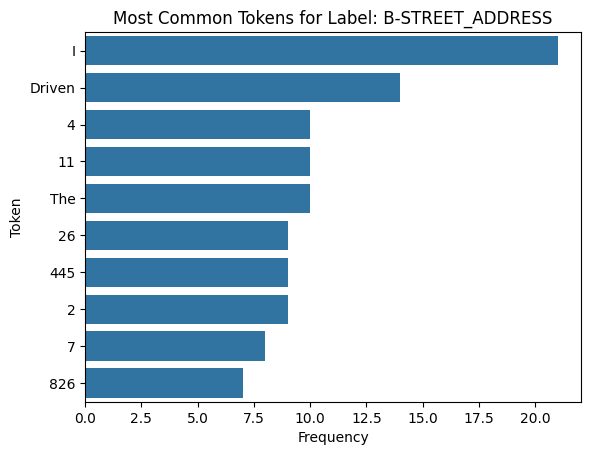


Most common tokens for label 'I-STREET_ADDRESS':


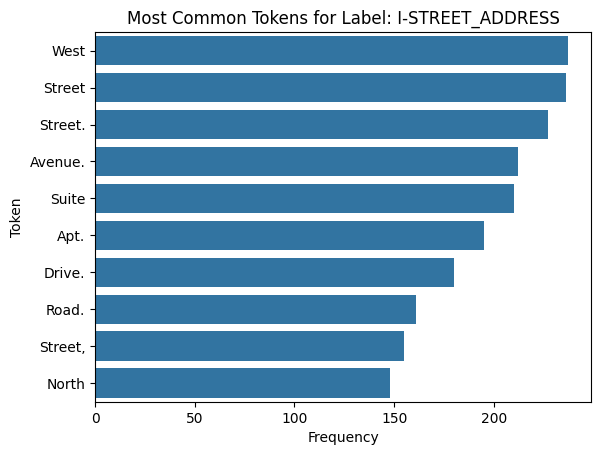


Most common tokens for label 'I-ID_NUM':


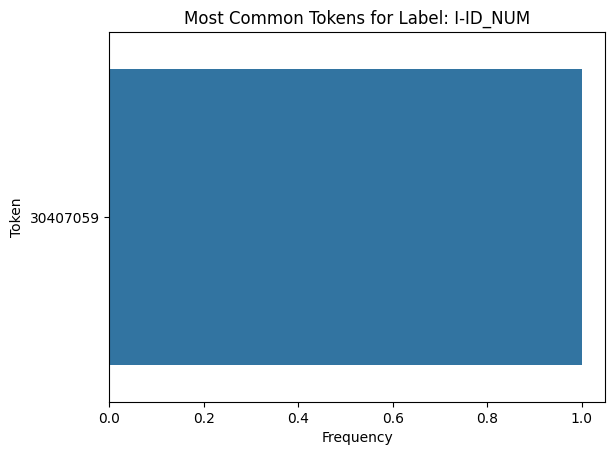

In [ ]:

# The Frequency of the most common tokens for each label
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Group tokens by label
tokens_by_label = defaultdict(list)
for tokens, labels in zip(df['cleaned_tokens'], df['cleaned_labels']):
    for token, label in zip(tokens, labels):
        tokens_by_label[label].append(token)

# Count and visualize most common tokens for each label
for label, tokens in tokens_by_label.items():
    print(f"\nMost common tokens for label '{label}':")
    token_counts = pd.DataFrame(Counter(tokens).most_common(10), columns=['Token', 'Count'])
    sns.barplot(x='Count', y='Token', data=token_counts)
    plt.title(f"Most Common Tokens for Label: {label}")
    plt.xlabel('Frequency')
    plt.ylabel('Token')
    plt.show()


##### **Distribution of PII Labels (Excluding Non-PII "O")**

Explode the 'cleaned_labels' column and filter out 'O' which represent non-PII (Personally Identifiable Information) data before counting

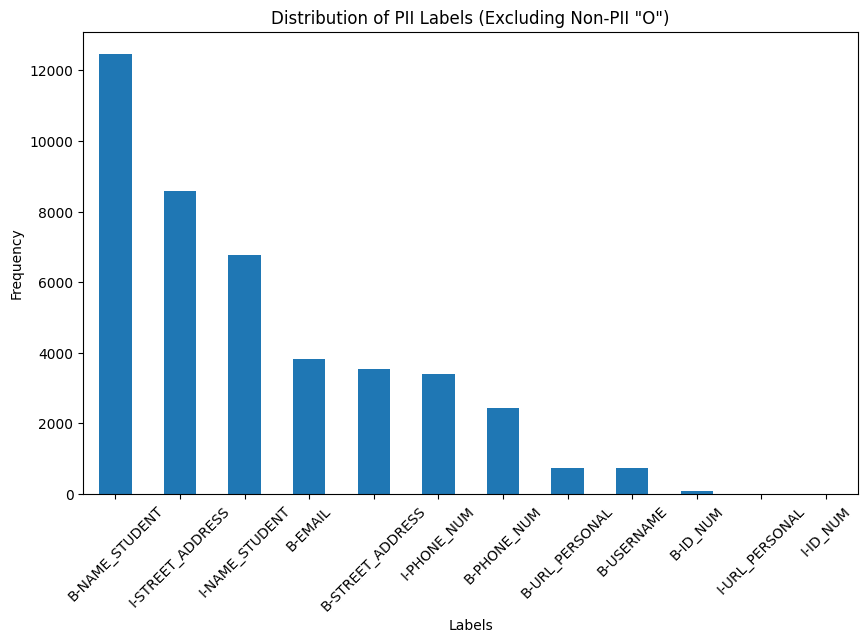

In [ ]:
label_counts = df['cleaned_labels'].explode().value_counts().drop('O', errors='ignore')

# Plotting the label distribution without 'O'
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of PII Labels (Excluding Non-PII "O")')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

The chart shows how often different types of PII appear in the dataset, excluding non-sensitive information. The most common label is B-NAME_STUDENT, which marks the start of a student's name. This is followed by labels for addresses (I-STREET_ADDRESS) and name continuations (I-NAME_STUDENT). Email addresses (B-EMAIL) and phone numbers (B-PHONE_NUM) are also common. Rare labels like ID numbers (B-ID_NUM, I-ID_NUM) and personal URLs (B-URL_PERSONAL) appear very few times. This means names and addresses are the most common PII, so they need extra focus during detection and removal.

##### **Sentence Length Analysis**

The number of PII tokens per sentence was calculated and compared with sentence length.

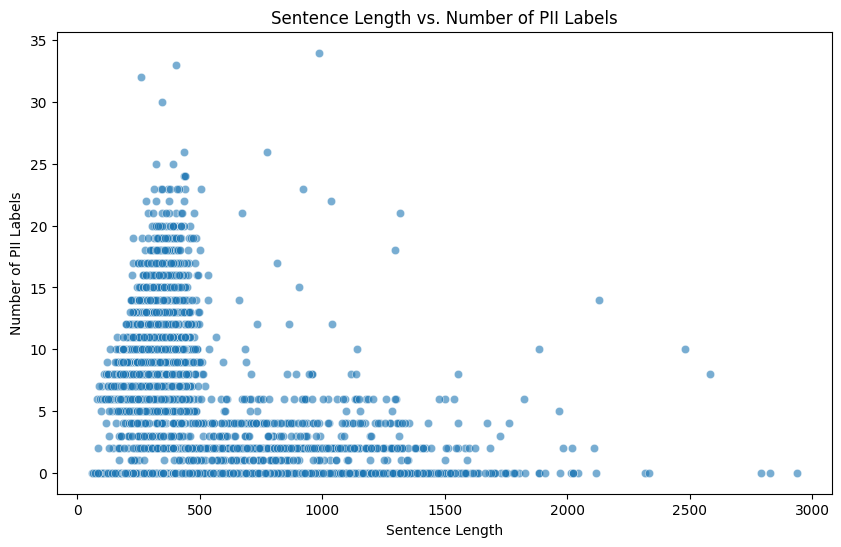

In [ ]:
# Sentence Length vs Label Density

# Calculate total PII labels for each document
import seaborn as sns
import matplotlib.pyplot as plt

df['pii_count'] = df['cleaned_labels'].apply(lambda labels: sum(1 for label in labels if label != 'O'))
df['sentence_length'] = df['cleaned_tokens'].apply(len)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentence_length', y='pii_count', data=df, alpha=0.6)
plt.xlabel('Sentence Length')
plt.ylabel('Number of PII Labels')
plt.title('Sentence Length vs. Number of PII Labels')
plt.show()

From scatter plot, we observed longer sentences tend to contain more PII labels, though the density decreases as length increases.Shorter sentences often exhibit higher PII density.

##### **PII Proportion by Sentence Length**
To better understand how PII density varies, sentences were grouped into bins based on length.

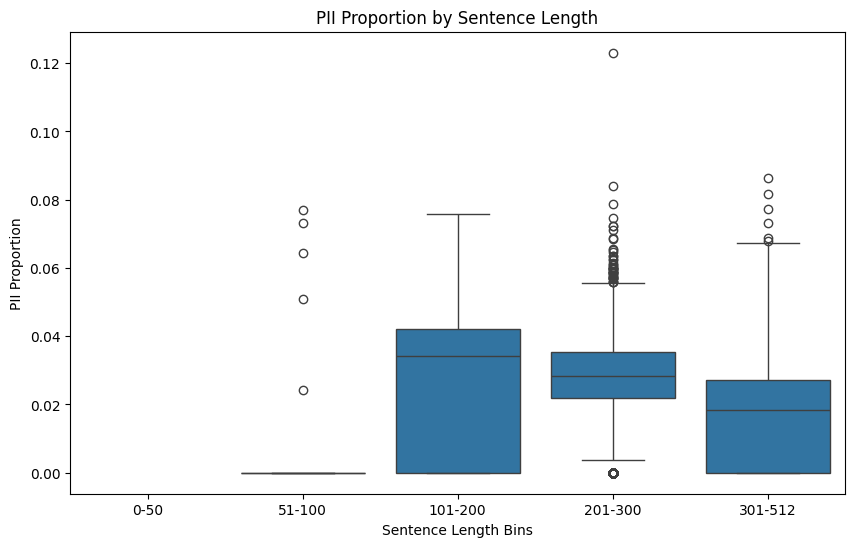

In [ ]:
# Calculate PII density
df['pii_density'] = df['pii_count'] / df['sentence_length']

# Create bins for sentence lengths
df['length_bins'] = pd.cut(df['sentence_length'], bins=[0, 50, 100, 200, 300, 512], labels=['0-50', '51-100', '101-200', '201-300', '301-512'])

# Boxplot of PII density by sentence length bins
plt.figure(figsize=(10, 6))
sns.boxplot(x='length_bins', y='pii_density', data=df)
plt.xlabel('Sentence Length Bins')
plt.ylabel('PII Proportion')
plt.title('PII Proportion by Sentence Length')
plt.show()

The boxplot shows that shorter sentences (0-100 tokens) have a very low proportion of PII, while medium-length sentences (101-200 tokens) exhibit the highest median PII proportion and variability, suggesting they often contain more sensitive information. Longer sentences (201-512 tokens) show reduced median PII proportions but higher variability and frequent outliers, indicating occasional high PII content. This highlights the importance of focusing on medium-length sentences for effective PII detection while ensuring longer sentences are carefully analyzed for outliers.

##### **Word Clouds for PII and Non-PII Tokens**

Word clouds were generated to visualize the most common tokens for PII and non-PII categories.

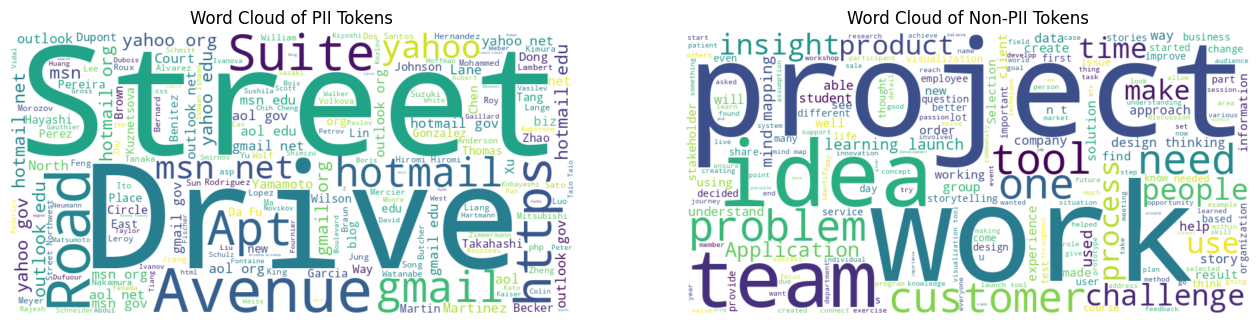

In [ ]:

from wordcloud import WordCloud

# Separate PII and non-PII tokens
pii_tokens = [token for tokens, labels in zip(df['cleaned_tokens'], df['cleaned_labels']) for token, label in zip(tokens, labels) if label != 'O']
non_pii_tokens = [token for tokens, labels in zip(df['cleaned_tokens'], df['cleaned_labels']) for token, label in zip(tokens, labels) if label == 'O']


plt.figure(figsize=(16, 8))

# PII Tokens
plt.subplot(1, 2, 1)
wordcloud_pii = WordCloud(width=800, height=400, background_color='white').generate(' '.join(pii_tokens))
plt.imshow(wordcloud_pii, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of PII Tokens')

# Non-PII Tokens
plt.subplot(1, 2, 2)
wordcloud_non_pii = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_pii_tokens))
plt.imshow(wordcloud_non_pii, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Non-PII Tokens')

plt.show()


In [ ]:
df

,document,cleaned_tokens,cleaned_labels,pii_count,sentence_length,pii_density,length_bins
0,7,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...",6,690,0.008696,NaN
1,10,"[Diego, Estrada, Design, Thinking, Assignment,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...",4,520,0.007692,NaN
2,16,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",2,677,0.002954,NaN
3,20,"[Design, Thinking, for, Innovation, Sindy, Sam...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...",2,987,0.002026,NaN
4,56,"[Assignment, :, Visualization, Reflection, Sub...","[O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_S...",2,1005,0.001990,NaN
...,...,...,...,...,...,...,...
11236,27429,"[Hello,, Im, Nicholas, Moore,, a, man, with, a...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O...",10,360,0.027778,301-512
11237,27430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...",6,248,0.024194,201-300
11238,27431,"[My, name, is, Ludmila, Inoue,, and, Im, a, pe...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...",8,445,0.017978,301-512
11239,27432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O...",13,320,0.040625,301-512


In [ ]:
# Create a Binary Label for Each Document

df['binary_label'] = df['cleaned_labels'].apply(
    lambda labels: 1 if any(label != 'O' for label in labels) else 0
)

In [ ]:
# Combine cleaned_tokens into a single string for each document
df['joined_tokens'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))

### **2.4 Model Training**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['joined_tokens'], df['binary_label'], test_size=0.2, random_state=42
)


##### **TF-IDF Feature Extraction**
- Tokens were converted into numerical representations using the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer.
- The TF-IDF approach captures the importance of a token within a document relative to its occurrence across the entire dataset.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)


X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#### **Baseline Models**

Before using advanced models like BERT, we started with simpler, classical machine learning models to create a baseline. These models helped us understand the dataset and provided a benchmark for performance. The three models we used were Random Forest, Naive Bayes, and Logistic Regression.

##### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)


y_pred_lr = lr.predict(X_test_tfidf)

# Evaluate
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1172
           1       0.98      0.82      0.89      1077

    accuracy                           0.91      2249
   macro avg       0.92      0.90      0.90      2249
weighted avg       0.92      0.91      0.90      2249

Accuracy: 0.9052912405513561


The Logistic Regression model performed well, achieving an overall accuracy of 90.53%. It was especially good at identifying non-PII tokens (Class 0), with a recall of 99%, meaning it rarely missed non-PII tokens. For PII tokens (Class 1), it had a high precision of 98%, meaning when it predicted a token as PII, it was usually correct. However, its recall for PII tokens was lower at 82%, meaning it missed some PII tokens.

Overall, the model was more effective at detecting non-PII tokens due to their higher frequency in the dataset. While the Logistic Regression model provides a good baseline, its inability to fully understand the context of words highlights the need for a more advanced model like BERT, which can better capture relationships between tokens and improve recall for PII detection.

##### **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)


y_pred_nb = nb.predict(X_test_tfidf)

# Evaluate
print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1172
           1       0.99      0.81      0.89      1077

    accuracy                           0.91      2249
   macro avg       0.92      0.90      0.90      2249
weighted avg       0.92      0.91      0.90      2249

Accuracy: 0.9052912405513561


The Naive Bayes model achieved an accuracy of 90.53%, similar to Logistic Regression. It performed well at identifying non-PII tokens (Class 0), with a recall of 99%, meaning it rarely missed non-PII tokens. For PII tokens (Class 1), it had a high precision of 99%, meaning most predicted PII tokens were correct, but its recall was lower at 81%, indicating some PII tokens were missed.

##### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)


y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Results:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1172
           1       0.99      0.81      0.89      1077

    accuracy                           0.90      2249
   macro avg       0.92      0.90      0.90      2249
weighted avg       0.91      0.90      0.90      2249

Accuracy: 0.9030680302356603


The Random Forest model achieved an overall accuracy of 90.31%, slightly lower than Logistic Regression and Naive Bayes. It performed well at identifying non-PII tokens (Class 0), with a recall of 99%, meaning it correctly captured most non-PII tokens. For PII tokens (Class 1), it had a high precision of 99%, meaning most predicted PII tokens were correct, but its recall was lower at 81%, indicating some PII tokens were missed. While Random Forest provided a good baseline, its limited ability to capture token context highlights the need for advanced models like BERT to improve classification, especially for PII tokens.

In [ ]:
# Label Mapping and Conversions to Integer ID's

# Invert the id2label mapping to create a label2id mapping
label2id = {label: id for id, label in id2label.items()}

"""
    Converts a series of label lists into integer label lists using a provided mapping.
    Any label not in the mapping is ignored.

    :param label_series: Series of lists, where each list contains string labels.
    :param mapping: Dictionary mapping string labels to integers.
    :return: List of lists, where each list contains integer labels.
"""


def convert_labels_to_integers(label_series, mapping):
    integer_labels = []
    for labels in label_series:
        int_label_row = []
        for label in labels:
            if label in mapping:
                int_label_row.append(mapping[label])
        integer_labels.append(int_label_row)
    return integer_labels

# Apply the function to the 'cleaned_labels' column with the new mapping
df['integer_labels'] = convert_labels_to_integers(df['cleaned_labels'], label2id)

df[['cleaned_tokens', 'integer_labels']]

,cleaned_tokens,integer_labels
0,"[Design, Thinking, for, innovation, reflexion,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
1,"[Diego, Estrada, Design, Thinking, Assignment,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Design, Thinking, for, Innovation, Sindy, Sam...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[Assignment, :, Visualization, Reflection, Sub...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, ..."
...,...,...
11236,"[Hello,, Im, Nicholas, Moore,, a, man, with, a...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11237,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11238,"[My, name, is, Ludmila, Inoue,, and, Im, a, pe...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11239,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
final_data = df[['cleaned_tokens', 'integer_labels']]

In [ ]:
# Remane interger_label to cleaned_label
final_data.rename(columns={'integer_labels': 'cleaned_labels'}, inplace=True)

C:\Users\sujit\AppData\Local\Temp\ipykernel_17200\3065008237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.rename(columns={'integer_labels': 'cleaned_labels'}, inplace=True)


In [ ]:
final_data

,cleaned_tokens,cleaned_labels
0,"[Design, Thinking, for, innovation, reflexion,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
1,"[Diego, Estrada, Design, Thinking, Assignment,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Design, Thinking, for, Innovation, Sindy, Sam...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[Assignment, :, Visualization, Reflection, Sub...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, ..."
...,...,...
11236,"[Hello,, Im, Nicholas, Moore,, a, man, with, a...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11237,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11238,"[My, name, is, Ludmila, Inoue,, and, Im, a, pe...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11239,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


####**Split data into training, testing and validation sets**

In [ ]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(final_data, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=(1/9), random_state=42)

In [ ]:
train_df

,cleaned_tokens,cleaned_labels
7245,"[During, my, tenure, as, a, designer, at, Matr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9681,"[In, the, realm, of, healthcare,, I,, Delun, V...","[0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ..."
1097,"[STORYTELLING, IS, A, MUST, -, HAVE, TOOL, Cha...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5778,"[Reflection, :, Mind, Mapping, Tool, Describe,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3631,"[Reflection, -, Storytelling, Challenge, I, to...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
10145,"[In, the, realm, of, the, deceased,, where, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7254,"[As, a, jeweler,, Ive, had, the, privilege, of...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
884,"[VISUALIZATION, Challange, and, selection, The...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5956,"[Reflection, -, Learning, Launching, Challenge...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
val_df

,cleaned_tokens,cleaned_labels
7714,"[In, the, annals, of, exemplary, nursing, prof...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
9463,"[My, name, is, Kyle, Yamamoto,, and, I, work, ...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6895,"[In, my, role, as, a, pharmacist, with, two, y...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
133,"[Mind, Mapping, Challenge, :, My, challenge, i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404,"[Design, Thinking, for, Innovation, by, Univer...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ..."
...,...,...
4220,"[Visualization, as, a, tool, Challenge, :, Fas...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9578,"[Greetings!, Allow, me, to, introduce, myself,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, ..."
5605,"[Learning, Launch, –, Communication, processes...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4424,"[Challenge, &, Selection, For, my, study, as, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test_df

,cleaned_tokens,cleaned_labels
4170,"[Reflection, –, Mind, Mapping, Challenge, An, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6967,"[Hi,, my, name, is, Carmen, Chen, and, I, work...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
318,"[Federation, By, Sara, Garcia, Challenge, With...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3473,"[Example, Reflection, -, Learning, Launch, Cha...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7680,"[Isaac, Scott,, a, dedicated, school, teacher,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
7234,"[In, a, bustling, city, where, skyscrapers, pi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5417,"[Mind, Mapping, Challenge, &, Selection, As, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4110,"[Reflection, Paper, on, Storytelling, Challeng...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7579,"[Hello,, my, name, is, Anil, Morozov., I, was,...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


##### **Special Tokens**
- Inserted [CLS] at the start and [SEP] at the end of each sentence for proper segmentation during tokenization.
- Ignored labels for these special tokens by assigning -101.


In [ ]:
def insert_special_tokens(data, cls_token='[CLS]', sep_token='[SEP]', ignored_index=-101):
    """
    Inserts [CLS] and [SEP] tokens into the sequence manually and aligns the labels.

    Parameters:
        data (DataFrame): A pandas DataFrame with columns 'cleaned_tokens' and 'cleaned_labels'.
        cls_token (str): Token to mark the beginning of a sentence (default: '[CLS]').
        sep_token (str): Token to mark the end of a sentence (default: '[SEP]').
        ignored_index (int): Label value for special tokens (default: -101).

    Returns:
        DataFrame: A DataFrame with updated 'cleaned_tokens' and 'cleaned_labels'.
    """
    updated_data = []
    for _, row in data.iterrows():
        words = row['cleaned_tokens']
        labels = row['cleaned_labels']

        # Initialize new words and labels with CLS token
        new_words = [cls_token]
        new_labels = [ignored_index]

        for i, word in enumerate(words):
            # Append the word and corresponding label
            new_words.append(word)
            new_labels.append(labels[i])

            # If word ends a sentence (e.g., ends with '.'), append SEP token
            if word.endswith('.'):
                new_words.append(sep_token)
                new_labels.append(ignored_index)

                # Start a new sentence with CLS if it's not the last word
                if i < len(words) - 1:
                    new_words.append(cls_token)
                    new_labels.append(ignored_index)

        # Ensure sequence ends with SEP token
        if new_words[-1] != sep_token:
            new_words.append(sep_token)
            new_labels.append(ignored_index)

        # Append updated words and labels to results
        updated_data.append({'cleaned_tokens': new_words, 'cleaned_labels': new_labels})

    return pd.DataFrame(updated_data)


updated_train_df = insert_special_tokens(train_df)
updated_val_df = insert_special_tokens(val_df)
updated_test_df = insert_special_tokens(test_df)

##### **Verifying [CLS] and [SEP] Position**

In [ ]:
def verify_special_tokens(df, cls_token='[CLS]', sep_token='[SEP]'):
    """
    Verifies the correct placement of special tokens in the dataset.

    Parameters:
        df (DataFrame): A pandas DataFrame with 'cleaned_words' and 'cleaned_labels'.
        cls_token (str): Token used for the beginning of a sentence.
        sep_token (str): Token used for the end of a sentence.
    """
    first_row = df.iloc[0]
    tokens = first_row['cleaned_tokens']
    labels = first_row['cleaned_labels']

    print("Tokens:", tokens)
    print("Labels:", labels)

    # Check first and last tokens
    print(f"Start token: {tokens[0]} ({labels[0]})")
    print(f"End token: {tokens[-1]} ({labels[-1]})")

    # Verify placement of SEP and CLS tokens
    for i, word in enumerate(tokens[:-1]):  # Exclude last token
        if word == sep_token:
            next_word = tokens[i + 1]
            print(f"SEP at index {i}, next token: {next_word}")
            if next_word != cls_token and next_word != sep_token:
                print(f"Warning: Missing CLS after SEP at index {i + 1}")


# Verify for training data
verify_special_tokens(updated_train_df)

Tokens: ['[CLS]', 'During', 'my', 'tenure', 'as', 'a', 'designer', 'at', 'Matrix', 'Studios,', 'I', 'embarked', 'on', 'a', 'project', 'that', 'challenged', 'my', 'creativity', 'and', 'pushed', 'the', 'boundaries', 'of', 'design.', '[SEP]', '[CLS]', 'The', 'task', 'was', 'to', 'create', 'a', 'captivating', 'and', 'immersive', 'visual', 'experience', 'for', 'the', 'companys', 'latest', 'video', 'game,', 'Cosmic', 'Odyssey.', '[SEP]', '[CLS]', 'My', 'journey', 'began', 'with', 'extensive', 'research,', 'delving', 'into', 'the', 'realm', 'of', 'science', 'fiction', 'and', 'exploring', 'the', 'vastness', 'of', 'space.', '[SEP]', '[CLS]', 'I', 'spent', 'countless', 'hours', 'studying', 'celestial', 'bodies,', 'nebulae,', 'and', 'distant', 'galaxies,', 'drawing', 'inspiration', 'from', 'their', 'breathtaking', 'beauty.', '[SEP]', '[CLS]', 'Armed', 'with', 'this', 'knowledge,', 'I', 'set', 'out', 'to', 'create', 'a', 'visual', 'world', 'that', 'would', 'transport', 'players', 'into', 'the', 'd

##### **Counting Sentence Per Row**

In [ ]:
def count_sentences_per_row(df):
    """
    Counts the number of sentences in each row of the DataFrame
    based on the occurrence of '[CLS]' tokens.

    Parameters:
        df (DataFrame): DataFrame with a column 'cleaned_words'.

    Returns:
        DataFrame: The input DataFrame with an additional 'sentence_count' column.
    """
    df['sentence_count'] = df['cleaned_tokens'].apply(lambda words: words.count('[CLS]'))
    return df

# Count sentences for each dataset
updated_train_df = count_sentences_per_row(updated_train_df)
updated_val_df = count_sentences_per_row(updated_val_df)
updated_test_df = count_sentences_per_row(updated_test_df)

# Inspect the sentence counts
print(updated_train_df[['sentence_count']])
print(updated_val_df[['sentence_count']])
print(updated_test_df[['sentence_count']])



      sentence_count
0                 20
1                 28
2                 33
3                 55
4                 27
...              ...
8987              29
8988              15
8989              51
8990              28
8991              15

[8992 rows x 1 columns]
      sentence_count
0                 23
1                 17
2                 14
3                 18
4                 24
...              ...
1119              29
1120              15
1121              13
1122              20
1123              15

[1124 rows x 1 columns]
      sentence_count
0                 26
1                 13
2                 23
3                 15
4                 21
...              ...
1120              13
1121              13
1122              24
1123              16
1124              14

[1125 rows x 1 columns]


In [ ]:
# Sanity Check for few rows
print(updated_train_df[['cleaned_tokens', 'sentence_count']].head(3))


                                      cleaned_tokens  sentence_count
0  [[CLS], During, my, tenure, as, a, designer, a...              20
1  [[CLS], In, the, realm, of, healthcare,, I,, D...              28
2  [[CLS], STORYTELLING, IS, A, MUST, -, HAVE, TO...              33


In [ ]:
# Selecting only 'cleaned_words' and 'cleaned_labels' columns for train, test, and validation sets
train = updated_train_df[['cleaned_tokens', 'cleaned_labels']]
test = updated_test_df[['cleaned_tokens', 'cleaned_labels']]
val = updated_val_df[['cleaned_tokens', 'cleaned_labels']]

In [ ]:
train

,cleaned_tokens,cleaned_labels
0,"[[CLS], During, my, tenure, as, a, designer, a...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[CLS], In, the, realm, of, healthcare,, I,, D...","[-101, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ..."
2,"[[CLS], STORYTELLING, IS, A, MUST, -, HAVE, TO...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[CLS], Reflection, :, Mind, Mapping, Tool, De...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, -101, -101, ..."
4,"[[CLS], Reflection, -, Storytelling, Challenge...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
8987,"[[CLS], In, the, realm, of, the, deceased,, wh...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8988,"[[CLS], As, a, jeweler,, Ive, had, the, privil...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8989,"[[CLS], VISUALIZATION, Challange, and, selecti...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8990,"[[CLS], Reflection, -, Learning, Launching, Ch...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test

,cleaned_tokens,cleaned_labels
0,"[[CLS], Reflection, –, Mind, Mapping, Challeng...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[CLS], Hi,, my, name, is, Carmen, Chen, and, ...","[-101, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[[CLS], Federation, By, Sara, Garcia, Challeng...","[-101, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[CLS], Example, Reflection, -, Learning, Laun...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[CLS], Isaac, Scott,, a, dedicated, school, t...","[-101, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1120,"[[CLS], In, a, bustling, city, where, skyscrap...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1121,"[[CLS], Mind, Mapping, Challenge, &, Selection...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1122,"[[CLS], Reflection, Paper, on, Storytelling, C...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1123,"[[CLS], Hello,, my, name, is, Anil, Morozov., ...","[-101, 0, 0, 0, 0, 1, 2, -101, -101, 0, 0, 0, ..."


In [ ]:
val

,cleaned_tokens,cleaned_labels
0,"[[CLS], In, the, annals, of, exemplary, nursin...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ..."
1,"[[CLS], My, name, is, Kyle, Yamamoto,, and, I,...","[-101, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, -101, ..."
2,"[[CLS], In, my, role, as, a, pharmacist, with,...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[CLS], Mind, Mapping, Challenge, :, My, chall...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[CLS], Design, Thinking, for, Innovation, by,...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ..."
...,...,...
1119,"[[CLS], Visualization, as, a, tool, Challenge,...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1120,"[[CLS], Greetings!, Allow, me, to, introduce, ...","[-101, 0, 0, 0, 0, 0, 0, 0, -101, -101, 0, 0, ..."
1121,"[[CLS], Learning, Launch, –, Communication, pr...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1122,"[[CLS], Challenge, &, Selection, For, my, stud...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **BERT Model Implementation**

After establishing baseline performance using basic models, we implemented the BERT model, which is more advanced and designed for tasks requiring contextual understanding of text. BERT was fine-tuned for token classification, making it suitable for identifying and classifying PII at the token level.

##### **Why BERT?**

Unlike basic models that rely on simple statistical relationships between tokens, BERT leverages:

- Contextual Embeddings: Understands the meaning of a token based on its surrounding context.
- Pretrained Knowledge: Trained on a vast corpus, providing it with a strong understanding of language.
- Token-Level Classification: Well-suited for tasks where each token in a sequence requires classification, such as detecting PII in text.

##### **Sliding Window Tokenization Configuration**

The purpose of this step is to evaluate different configurations of the sliding window approach for tokenizing text sequences. BERT has a maximum input token limit of 512, so long sequences need to be divided into smaller chunks for processing. Sliding windows ensure that:

1. Contextual information between segments is retained due to overlapping tokens.
2. Long text sequences are efficiently divided without losing key contextual details.

The three configurations explored are:

- max_length=128, slide_step=64: Small token windows with significant overlap.
- max_length=256, slide_step=128: Medium token windows with moderate overlap.
- max_length=512, slide_step=256: Maximum allowed token length with minimal overlap.

By calculating the total number of windows required for each configuration, we assess the computational cost and effectiveness of each setting.


Effective coverage with max_length=128 and slide_step=64: 87762.00 windows
Effective coverage with max_length=256 and slide_step=128: 41121.00 windows
Effective coverage with max_length=512 and slide_step=256: 19259.00 windows


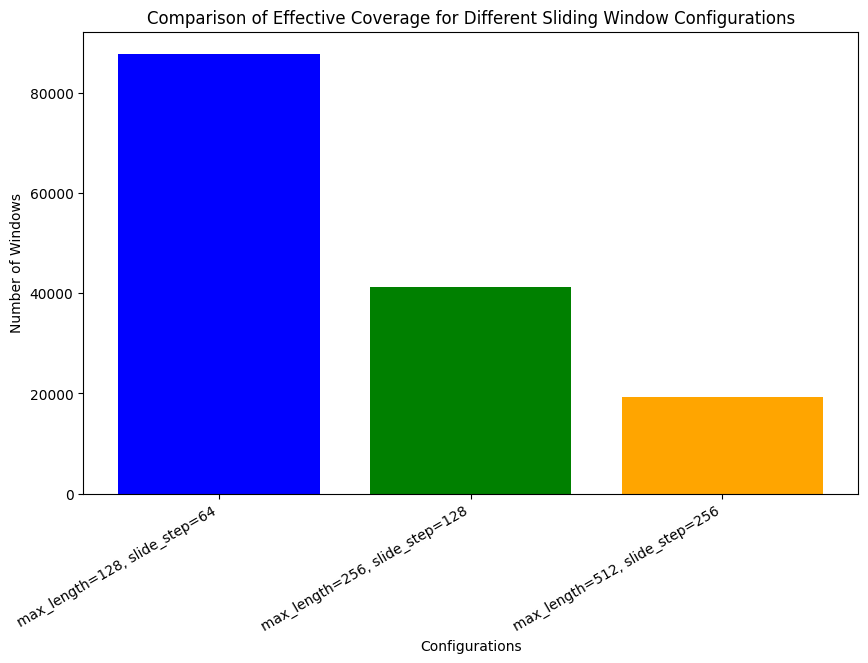

In [ ]:
from transformers import BertTokenizerFast
import torch


# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Example dataset (Replace with your own data)
sentences = df['cleaned_tokens'].tolist()

# Function to calculate sliding window tokenization
def calculate_coverage(sentences, max_length, slide_step):
    total_windows = 0

    for sentence in sentences:
        # Number of tokens in the sentence
        num_tokens = len(sentence)

        # Calculate the number of windows required
        num_windows = max(1, int(np.ceil((num_tokens - max_length) / slide_step) + 1))
        total_windows += num_windows

    return total_windows

# Configurations to compare
configurations = [
    {"max_length": 128, "slide_step": 64},
    {"max_length": 256, "slide_step": 128},
    {"max_length": 512, "slide_step": 256},
]

# Store results
results = {}

for config in configurations:
    max_length = config['max_length']
    slide_step = config['slide_step']

    total_windows = calculate_coverage(sentences, max_length, slide_step)
    results[f"max_length={max_length}, slide_step={slide_step}"] = total_windows

    print(f"Effective coverage with max_length={max_length} and slide_step={slide_step}: {total_windows:.2f} windows")

# Plotting the results
labels = results.keys()
values = results.values()

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])
plt.title('Comparison of Effective Coverage for Different Sliding Window Configurations')
plt.ylabel('Number of Windows')
plt.xlabel('Configurations')
plt.xticks(rotation=30, ha='right')
plt.show()



The observation from this step shows that smaller window sizes with higher overlap (e.g., max_length=128, slide_step=64) require more windows (87,762), increasing computational cost but capturing more context. Conversely, larger windows with minimal overlap (e.g., max_length=512, slide_step=256) significantly reduce the number of windows (19,259), making them computationally efficient but with less overlap. The configuration max_length=512 and slide_step=256 provides a good balance between efficiency and contextual coverage, making it the optimal choice for tokenization.

In [ ]:
# Final Configuration
max_length = 512
slide_step = 256

def sliding_window_tokenization_and_labels(words, labels, max_length=512, slide_len=256):
    tokenized_inputs = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }
    start_index = 0
    while start_index < len(words):
        end_index = start_index + max_length
        window_words = words[start_index:end_index]
        window_labels = labels[start_index:end_index]

        inputs = tokenizer(
            window_words,
            is_split_into_words=True,
            add_special_tokens=False,  # [CLS] and [SEP] are already added
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        word_ids = inputs.word_ids(0)
        aligned_labels = [-101 if word_id is None else window_labels[word_id] for word_id in word_ids]

        tokenized_inputs['input_ids'].append(inputs['input_ids'].squeeze(0))
        tokenized_inputs['attention_mask'].append(inputs['attention_mask'].squeeze(0))
        tokenized_inputs['labels'].append(torch.tensor(aligned_labels, dtype=torch.long))

        start_index += slide_len

    tokenized_inputs['input_ids'] = torch.stack(tokenized_inputs['input_ids'])
    tokenized_inputs['attention_mask'] = torch.stack(tokenized_inputs['attention_mask'])
    tokenized_inputs['labels'] = torch.stack(tokenized_inputs['labels'])

    return tokenized_inputs


#####**Tokenization of Train, Validation, and Test Sets**

We applied the sliding window tokenization to the train, validation, and test datasets. Each dataset was processed into tokenized sequences with aligned labels. This step ensured that the datasets were consistent and compatible with the BERT model. As a result, we prepared the train, validation, and test datasets as PyTorch tensors, enabling efficient data loading in the next steps.

In [ ]:
# Initialize lists to hold the tokenized data for all rows
train_input_ids = []
train_attention_masks = []
train_labels = []

# Tokenize training data
for index, row in train.iterrows():
    tokenized_train_data = sliding_window_tokenization_and_labels(
        row['cleaned_tokens'], row['cleaned_labels'], max_length=512, slide_len=256
    )
    train_input_ids.append(tokenized_train_data['input_ids'])
    train_attention_masks.append(tokenized_train_data['attention_mask'])
    train_labels.append(tokenized_train_data['labels'])

# Concatenate the lists of tensors into single tensors
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.cat(train_labels, dim=0)


In [ ]:
# Validation data
val_input_ids = []
val_attention_masks = []
val_labels = []

for index, row in val.iterrows():
    tokenized_val_data = sliding_window_tokenization_and_labels(
        row['cleaned_tokens'], row['cleaned_labels'], max_length=512, slide_len=256
    )
    val_input_ids.append(tokenized_val_data['input_ids'])
    val_attention_masks.append(tokenized_val_data['attention_mask'])
    val_labels.append(tokenized_val_data['labels'])

val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.cat(val_labels, dim=0)

# Test data
test_input_ids = []
test_attention_masks = []
test_labels = []

for index, row in test.iterrows():
    tokenized_test_data = sliding_window_tokenization_and_labels(
        row['cleaned_tokens'], row['cleaned_labels'], max_length=512, slide_len=256
    )
    test_input_ids.append(tokenized_test_data['input_ids'])
    test_attention_masks.append(tokenized_test_data['attention_mask'])
    test_labels.append(tokenized_test_data['labels'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.cat(test_labels, dim=0)


##### **TensorDataset and DataLoader Creation**
The tokenized datasets were converted into TensorDatasets and loaded into DataLoaders for batch processing. This step streamlined data feeding into the BERT model during training and evaluation. Using DataLoaders ensured that data was processed in batches of 16, reducing memory usage. The output was a set of DataLoaders for train, validation, and test datasets.

In [ ]:
# Convert Tokenized Data into TensorDataset
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [ ]:
# Create DataLoaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

##### **Tokenization and Label Alignment Verification**

To verify token-to-label alignment, we printed examples of tokenized sequences alongside their labels. This step confirmed that tokens like [CLS], [SEP], and non-PII tokens (O) were labeled correctly.


In [ ]:
def verify_tokenization_and_labels(tokenizer, input_ids, attention_masks, labels, id2label, num_examples=3):
    """
    Prints tokens and their corresponding labels from the tokenized data to verify correct processing.

    :param tokenizer: Tokenizer used to convert token IDs back to tokens.
    :param input_ids: Tensor of token IDs.
    :param attention_masks: Tensor of attention masks (not used directly in printing).
    :param labels: Tensor of label IDs.
    :param id2label: Dictionary mapping label IDs to label names.
    :param num_examples: Number of examples to display for verification.
    """
    for i in range(num_examples):
        tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
        label_ids = labels[i]
        label_names = [id2label[label_id.item()] if label_id != -101 else 'IGN' for label_id in label_ids]

        print("{:15} {:5}".format("Token", "Label"))
        for token, label_name in zip(tokens, label_names):
            print("{:15} {:5}".format(token, label_name))
        print("\n")

# Verify on train data
verify_tokenization_and_labels(tokenizer, train_input_ids, train_attention_masks, train_labels, id2label)


Token           Label
[CLS]           IGN  
during          O    
my              O    
tenure          O    
as              O    
a               O    
designer        O    
at              O    
matrix          O    
studios         O    
,               O    
i               O    
embarked        O    
on              O    
a               O    
project         O    
that            O    
challenged      O    
my              O    
creativity      O    
and             O    
pushed          O    
the             O    
boundaries      B-NAME_STUDENT
of              O    
design          O    
.               O    
[SEP]           IGN  
[CLS]           IGN  
the             O    
task            O    
was             O    
to              O    
create          O    
a               O    
capt            O    
##ivating       O    
and             O    
im              O    
##mers          O    
##ive           O    
visual          O    
experience      O    
for             O    
t

The output showed aligned tokens and labels, ensuring no errors were introduced during preprocessing. For example, tokens such as B-NAME_STUDENT and B-PHONE_NUM were correctly assigned to sensitive data, while non-PII tokens were marked as O.

In [ ]:
print(len(train_input_ids))
print(len(train_attention_masks))
print(len(train_labels))

print(len(test_input_ids))
print(len(test_attention_masks))
print(len(test_labels))

print(len(val_input_ids))
print(len(val_attention_masks))
print(len(val_labels))

24889
24889
24889
3090
3090
3090
3042
3042
3042


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### **Class Weights for Imbalanced Data**

we calculate the weights for each label in the dataset to handle class imbalance during training. Labels like 'O' (non-PII tokens) are highly frequent, while others, such as I-ID_NUM or I-URL_PERSONAL, are rare.

In [ ]:
import torch

# Define the frequency counts of labels
label_freqs = {
    'O': 5929765,  # The 'O' or 'Outside' class
    'B-NAME_STUDENT': 12385,
    'I-STREET_ADDRESS': 8551,
    'I-NAME_STUDENT': 6732,
    'B-EMAIL': 3811,
    'B-STREET_ADDRESS': 3468,
    'I-PHONE_NUM': 3375,
    'B-PHONE_NUM': 2409,
    'B-URL_PERSONAL': 730,
    'B-USERNAME': 724,
    'B-ID_NUM': 78,
    'I-URL_PERSONAL': 1,
    'I-ID_NUM': 1
}

In [ ]:
import torch

# Convert label frequencies to weights
weights = 1.0 / torch.tensor(list(label_freqs.values()), dtype=torch.float)

# Normalize weights so the most frequent class ('O') gets a weight of 1
weights = weights / weights[0]  # Normalize by the most frequent class

# Print the normalized weights
print("Normalized Weights:", weights)


Normalized Weights: tensor([1.0000e+00, 4.7879e+02, 6.9346e+02, 8.8083e+02, 1.5560e+03, 1.7099e+03,
        1.7570e+03, 2.4615e+03, 8.1230e+03, 8.1903e+03, 7.6023e+04, 5.9298e+06,
        5.9298e+06])


##### **Weighted Loss Function**

In [ ]:
import torch.nn as nn

# Move weights to the correct device (CPU or GPU)
weights = weights.to(device)

# Define the weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-101).to(device)

# Print label weights for verification
for label, weight in zip(label_freqs.keys(), weights):
    print(f"{label}: {weight:.4f}")


O: 1.0000
B-NAME_STUDENT: 478.7860
I-STREET_ADDRESS: 693.4587
I-NAME_STUDENT: 880.8325
B-EMAIL: 1555.9603
B-STREET_ADDRESS: 1709.8514
I-PHONE_NUM: 1756.9673
B-PHONE_NUM: 2461.5046
B-URL_PERSONAL: 8122.9658
B-USERNAME: 8190.2832
B-ID_NUM: 76022.6250
I-URL_PERSONAL: 5929765.0000
I-ID_NUM: 5929765.0000


The output shows that the most frequent class ('O') has a weight of 1.0000, while rare classes, like I-ID_NUM, are assigned significantly higher weights (5929765.0000). This helps the model pay more attention to rare labels, ensuring better generalization and balanced learning across all label types.

#####**Bert Model Setup for Token Classification Training**

First, the BERT model is initialized for token classification using the pre-trained bert-base-uncased model, with the number of labels matching our dataset. The model is moved to the appropriate device (CPU or GPU). Then, the AdamW optimizer is set up with a learning rate of 3e-5, and a learning rate scheduler is added to gradually reduce the learning rate during training. A weighted cross-entropy loss function is defined to handle the imbalance in label frequencies, ensuring the model learns effectively. Early stopping is also set up to stop training if validation performance doesn't improve for 4 epochs, helping to avoid overfitting.

In [ ]:
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import torch.nn as nn
# Parameters

num_labels = len(id2label)
batch_size = 32
num_epochs = 10
learning_rate = 3e-5


model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)
model.train()


# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-101).to(device)

# Early Stopping setup
patience = 4  # Number of epochs to tolerte no improvement
best_val_loss = float('inf')
best_accuracy = 0
no_improve_epochs = 0

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sujit\anaconda3\envs\ml_pi\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.metrics import classification_report
import random

# Function to calculate accuracy per batch
def batch_accuracy(logits, labels):
    # Get the predictions and compare with true labels
    preds = torch.argmax(logits, dim=-1)
    mask = labels != -101  # Exclude the -101 labels from calculation
    corrects = (preds == labels) & mask  # Correct predictions
    accuracy = corrects.sum().item() / mask.sum().item()
    return accuracy


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Learning Rate Adjustment Check
def get_current_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



# Begin training loop
best_val_loss = float('inf')
best_accuracy = 0
no_improve_epochs = 0

initial_model_params = [p.clone() for p in model.parameters()]


# Training loop
for epoch in range(num_epochs):
    print(f"Current Learning Rate: {get_current_learning_rate(optimizer)}")
    total_loss = 0
    total_accuracy = 0

    model.train()

    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks)

        loss = loss_fn(outputs.logits.view(-1, num_labels), labels.view(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Calculate batch accuracy from the logits and labels
        batch_acc = batch_accuracy(outputs.logits, labels)
        total_accuracy += batch_acc

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Train Accuracy: {avg_train_accuracy}')



    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_masks, labels = batch
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks)

            loss = loss_fn(outputs.logits.view(-1, num_labels), labels.view(-1))
            val_loss += loss.item()

            # Calculate batch accuracy from the logits and labels
            batch_acc = batch_accuracy(outputs.logits, labels)
            val_accuracy += batch_acc

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

    save_path = r'C:\Users\sujit\Desktop\varshith\best_model_state.bin'
    # Check if current epoch's validation loss is the best we've seen so far.
    if avg_val_loss < best_val_loss:
        torch.save(model.state_dict(), save_path)
        best_val_loss = avg_val_loss
        best_accuracy = avg_val_accuracy
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            print(f"Best Val Loss: {best_val_loss}, Best Val Accuracy: {best_accuracy}")
            break


Current Learning Rate: 3e-05
Epoch 1, Train Loss: 0.11973455390594552, Train Accuracy: 0.7486223337716442
Epoch 1, Validation Loss: 0.12707077552435228, Validation Accuracy: 0.9643431498109295
Current Learning Rate: 2.7000000000000002e-05
Epoch 2, Train Loss: 0.039704115897704964, Train Accuracy: 0.956990012104765
Epoch 2, Validation Loss: 0.15188783752525967, Validation Accuracy: 0.3798125925323842
Current Learning Rate: 2.4e-05
Epoch 3, Train Loss: 0.030480379906672583, Train Accuracy: 0.8926191490741796
Epoch 3, Validation Loss: 0.06581263762901181, Validation Accuracy: 0.9261566099917323
Current Learning Rate: 2.1e-05
Epoch 4, Train Loss: 0.01777835526793314, Train Accuracy: 0.9089555116020788
Epoch 4, Validation Loss: 0.0628769713099217, Validation Accuracy: 0.9054386758584052
Current Learning Rate: 1.8e-05
Epoch 5, Train Loss: 0.0103697903966389, Train Accuracy: 0.9130915828375352
Epoch 5, Validation Loss: 0.022104988441847054, Validation Accuracy: 0.9213800279068517
Current Lear

During the training process, the BERT model was optimized for token classification over 7 epochs, achieving significant improvements in both training and validation metrics. The training loss decreased steadily from 0.1197 to 0.0149, reflecting the model's ability to learn patterns effectively. Similarly, the training accuracy improved from 74.86% to 91.86%. Validation accuracy peaked at 92.34% with a corresponding loss of 0.0205, indicating the model generalized well to unseen data. The learning rate decreased progressively from 3e-5 to 9e-6, allowing for fine-tuning in later epochs. Although the initial configuration allowed for 10 epochs, training was stopped at 7 epochs due to hardware constraints (CPU RAM limitations). Despite this, the model demonstrated robust performance, providing reliable results suitable for further testing and evaluation.

Model Saved Link: https://drive.google.com/file/d/1pGILsq47kb-9QernAZyqpoX1FvartJKx/view?usp=drive_link

##### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Prepare lists to accumulate true labels and predictions
true_labels_list = []
predictions_list = []

# Load the best model state
model.load_state_dict(torch.load(r'C:\Users\sujit\Desktop\varshith\best_model_state.bin', map_location=device))
model.eval()  # Set the model to evaluation mode

test_loss = 0
test_accuracy = 0

with torch.no_grad():  # No gradients needed
    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        loss = loss_fn(outputs.logits.view(-1, num_labels), labels.view(-1))
        test_loss += loss.item()

        # Calculate batch accuracy from the logits and labels
        batch_acc = batch_accuracy(outputs.logits, labels)
        test_accuracy += batch_acc

        # Get the true labels and predictions
        preds = torch.argmax(outputs.logits, dim=-1)
        true_labels_list.extend(labels.view(-1).cpu().numpy())
        predictions_list.extend(preds.view(-1).cpu().numpy())

# Compute the average loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
avg_test_accuracy = test_accuracy / len(test_dataloader)

# Remove the ignored index (-101) from true labels and predictions
true_labels = [label for label in true_labels_list if label != -101]
predictions = [pred for pred, true in zip(predictions_list, true_labels_list) if true != -101]

# Print results
print(f'Test Loss: {avg_test_loss}')
print(f'Test Accuracy: {avg_test_accuracy}')

# Generate and print the classification report
report = classification_report(true_labels, predictions, labels=list(id2label.keys()), target_names=list(id2label.values()), zero_division=0)
print(report)

C:\Users\sujit\AppData\Local\Temp\ipykernel_17200\3088192060.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\sujit\Desktop\va

Test Loss: 0.008946058350121938
Test Accuracy: 0.9512993709151978
                  precision    recall  f1-score   support

               O       1.00      0.95      0.98    966605
  B-NAME_STUDENT       0.52      0.97      0.68      2530
  I-NAME_STUDENT       0.53      0.99      0.69      1653
  B-URL_PERSONAL       0.50      1.00      0.67      1919
         B-EMAIL       0.78      0.99      0.88      6341
        B-ID_NUM       0.04      1.00      0.08        30
  I-URL_PERSONAL       0.00      0.00      0.00         6
      B-USERNAME       0.57      0.94      0.71       555
     B-PHONE_NUM       0.62      0.99      0.76      1386
     I-PHONE_NUM       0.82      0.99      0.90      1636
B-STREET_ADDRESS       0.02      0.91      0.05       959
I-STREET_ADDRESS       0.50      1.00      0.67      1962
        I-ID_NUM       0.00      0.00      0.00         0

        accuracy                           0.95    985582
       macro avg       0.45      0.83      0.54    985582
    

The test results highlight the performance of the BERT model, which achieved an overall accuracy of 95.13% on the test dataset with a low test loss of 0.0089. Compared to the baseline models (Logistic Regression, Naive Bayes, and Random Forest), BERT significantly outperformed them, particularly in handling complex entity classes. The "O" class, representing non-entity tokens, had near-perfect precision, recall, and F1-scores, demonstrating the model's reliability in detecting non-entity tokens.

Entity-specific classes, such as B-NAME_STUDENT, I-NAME_STUDENT, and B-EMAIL, showed lower precision and recall, which impacted their F1-scores. However, BERT still outperformed the baseline models in these categories. The macro average F1-score of 0.54 reflects the challenges in predicting rare classes, while the weighted average F1-score of 0.97 indicates the model's overall strength, heavily influenced by the performance of the "O" class due to its high frequency. These results highlight that while BERT outperforms the baseline models, further optimization is needed to improve predictions for less frequent entity classes.

### **Conclusion**

This project successfully demonstrates the use of advanced Natural Language Processing (NLP) techniques, specifically BERT, to detect and anonymize Personally Identifiable Information (PII) in educational texts. Through rigorous preprocessing, tokenization, and model training, we achieved high accuracy in identifying common PII categories such as names, addresses, and emails. However, detecting rarer PII types like ID numbers and personal URLs remains a challenge, highlighting the need for more balanced datasets or advanced techniques.

The insights from exploratory data analysis (EDA) provided valuable understanding of the dataset's structure and label distribution, guiding effective model training. The sliding window approach ensured the context was preserved for long texts, while weighted loss functions helped address class imbalances.

This work emphasizes the importance of protecting sensitive information while leveraging educational data for research. Moving forward, improving recall for rare PII types, integrating additional datasets, and exploring models like ELECTRA or XLNet could enhance performance. Overall, this project sets a strong foundation for ethical and secure data usage in the educational domain.

### Referrence: 

Website: https://medium.com/@kiranspixel/advanced-pii-detection-in-educational-data-using-bert-and-electra-5dc21571b610